In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Cargar el archivo CSV
df = pd.read_csv("D:/x-ray chest/locating/TBX11k_simplified/tbx11k-simplified/data.csv")

# Preprocesamiento de las imágenes
image_dir = 'D:/x-ray chest/locating/TBX11k_simplified/tbx11k-simplified/images'


In [3]:
# Función para cargar imágenes y preprocesarlas
def load_image(fname, img_size=(128, 128)):
    img_path = os.path.join(image_dir, fname)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error loading image: {img_path}")
        return None
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalización
    return img


# Cargar las imágenes y preparar etiquetas para las tres tareas
images = []
tb_labels = []
bbox_labels = []
severity_labels = []
sources = []

for i, row in df.iterrows():
    img = load_image(row['fname'])
    if img is not None: # Only append if image loaded correctly
        images.append(img)

        if row['target'] == 'tb':
            tb_labels.append(1)
        else:
            tb_labels.append(0)

        # Etiquetas para la localización de áreas afectadas (si no hay infección, bbox es [0,0,0,0])
        if row['bbox'] != 'none':
            bbox = eval(row['bbox'])
            bbox_labels.append([bbox['xmin'], bbox['ymin'], bbox['width'], bbox['height']])
        else:
            bbox_labels.append([0, 0, 0, 0])

        # Etiquetas para la severidad de la infección (TB activa/latente)
        if row['tb_type'] == 'active_tb':
            severity_labels.append(2)  # TB activa
        elif row['tb_type'] == 'latent_tb':
            severity_labels.append(1)  # TB latente
        else:
            severity_labels.append(0)  # No TB

        # Append source for each image
        sources.append(row['source']) # Assuming your CSV has a column named 'source'



In [4]:
# Convertir listas a arrays de numpy
X = np.array(images)
y_tb = to_categorical(tb_labels, num_classes=2)  # Clasificación binaria
y_bbox = np.array(bbox_labels)  # Localización
y_severity = to_categorical(severity_labels, num_classes=3)  # Severidad (none, latent_tb, active_tb)
sources = np.array(sources)

# Filtrar las imágenes de entrenamiento y validación
X_train = X[sources == 'train']
X_val = X[sources == 'val']

y_tb_train = y_tb[sources == 'train']
y_tb_val = y_tb[sources == 'val']

y_bbox_train = y_bbox[sources == 'train']
y_bbox_val = y_bbox[sources == 'val']

y_severity_train = y_severity[sources == 'train']
y_severity_val = y_severity[sources == 'val']

# Arquitectura del modelo para las tres tareas
input_img = Input(shape=(128, 128, 1))

# Bloque de Redes Neuronales Convolucionales
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)

# Rama para la clasificación binaria
tb_output = Dense(2, activation='softmax', name='tb_output')(x)

# Rama para la localización (regresión)
bbox_output = Dense(4, activation='linear', name='bbox_output')(x)

# Rama para la severidad (clasificación en tres categorías)
severity_output = Dense(3, activation='softmax', name='severity_output')(x)

# Crear el modelo
model = Model(inputs=input_img, outputs=[tb_output, bbox_output, severity_output])

# Compilar el modelo
model.compile(optimizer='adam',
              loss={'tb_output': 'binary_crossentropy', 'bbox_output': 'mean_squared_error', 'severity_output': 'categorical_crossentropy'},
              metrics={'tb_output': ['accuracy', 'AUC'], 'bbox_output': 'mse', 'severity_output': 'accuracy'})

In [5]:

history = model.fit(
    X_train,
    {'tb_output': y_tb_train, 'bbox_output': y_bbox_train, 'severity_output': y_severity_train},
    validation_data=(X_val, {'tb_output': y_tb_val, 'bbox_output': y_bbox_val, 'severity_output': y_severity_val}),
    epochs=10,
    batch_size=64
)

Epoch 1/10
108/108 [==============================] - 89s 340ms/step - loss: 2643.8896 - tb_output_loss: 0.4004 - bbox_output_loss: 2642.9814 - severity_output_loss: 0.5085 - tb_output_accuracy: 0.8822 - tb_output_auc: 0.9058 - bbox_output_mse: 2642.9814 - severity_output_accuracy: 0.8653 - val_loss: 2460.4058 - val_tb_output_loss: 0.3036 - val_bbox_output_loss: 2459.5215 - val_severity_output_loss: 0.5806 - val_tb_output_accuracy: 0.8790 - val_tb_output_auc: 0.9390 - val_bbox_output_mse: 2459.5215 - val_severity_output_accuracy: 0.8523
Epoch 2/10
108/108 [==============================] - 32s 295ms/step - loss: 1722.0922 - tb_output_loss: 0.2277 - bbox_output_loss: 1721.4618 - severity_output_loss: 0.4030 - tb_output_accuracy: 0.9342 - tb_output_auc: 0.9598 - bbox_output_mse: 1721.4618 - severity_output_accuracy: 0.9097 - val_loss: 1797.6139 - val_tb_output_loss: 0.2181 - val_bbox_output_loss: 1797.0251 - val_severity_output_loss: 0.3706 - val_tb_output_accuracy: 0.9272 - val_tb_outpu

In [6]:
model.save('new_model_locating.h5')

60/60 [==============================] - 2s 37ms/step


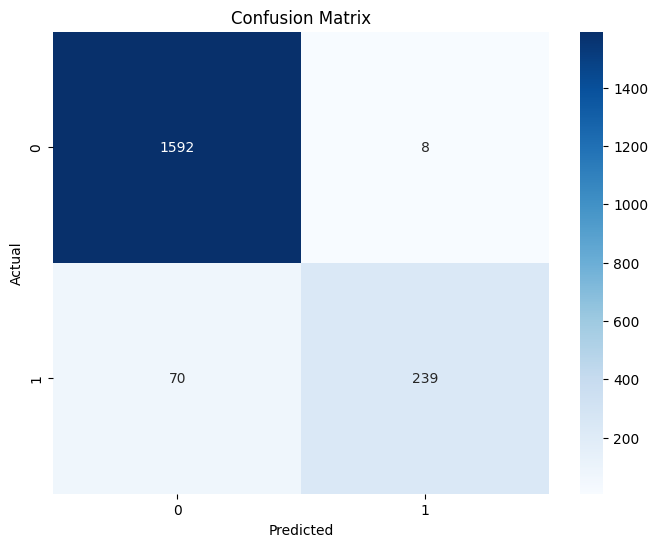

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Predicciones para la matriz de confusión
y_pred = model.predict(X_val)[0] # Obtener las predicciones de la salida 'tb_output'
y_pred_classes = np.argmax(y_pred, axis=1) # Convertir las probabilidades a clases (0 o 1)
y_true_classes = np.argmax(y_tb_val, axis=1) # Obtener las clases verdaderas

# Calcular la matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

60/60 [==============================] - 2s 37ms/step


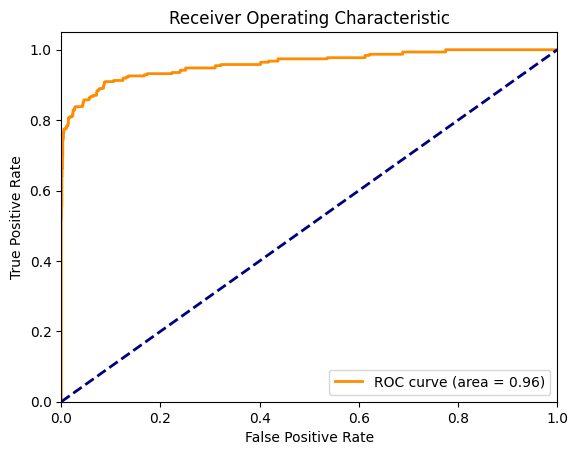

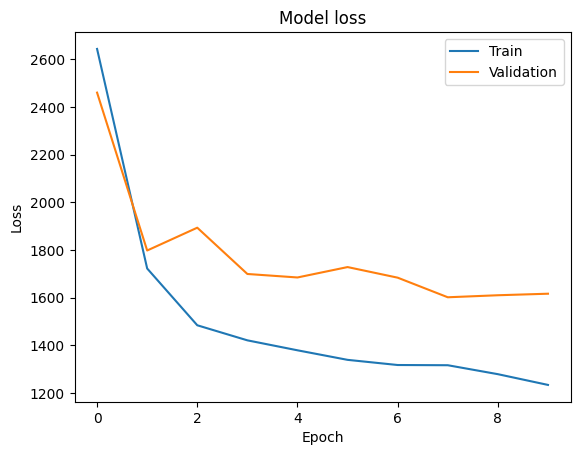

In [10]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = model.predict(X_val)[0] # Obtener las probabilidades de la salida 'tb_output'
fpr, tpr, thresholds = roc_curve(y_tb_val[:, 1], y_pred_prob[:, 1]) # Calcular la curva ROC (usando la clase positiva)
roc_auc = auc(fpr, tpr) # Calcular el área bajo la curva ROC

# Gráfico de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Gráfico de validación vs pérdida
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [13]:
import os
import csv
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Cargar el modelo
model = load_model('D:/x-ray chest/locating/new_model_locating.h5')

# Directorio de imágenes
images_dir = 'D:/x-ray chest/locating/TBX11k_simplified/tbx11k-simplified/test'

# Crear archivo CSV
csv_file = open('D:\x-ray chest\locating\TBX11k_simplified\tbx11k-simplified\data.csv', 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['nombre_imagen', 'clasificacion', 'localizacion', 'tipo_tb'])

# Procesar cada imagen en la carpeta
for filename in os.listdir(images_dir):
  if filename.endswith(".jpg") or filename.endswith(".png"): # Asegurar que solo se procesen imágenes
    img_path = os.path.join(images_dir, filename)

    # Cargar y preprocesar la imagen
    img = load_img(img_path, target_size=(128, 128), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalizar
    img_array = np.expand_dims(img_array, axis=0)

    # Obtener predicciones del modelo
    tb_pred, bbox_pred, severity_pred = model.predict(img_array)

    # Clasificación (tb o no tb)
    tb_class = "tb" if tb_pred[0][1] > 0.5 else "no tb"

    # Localización (bbox)
    if tb_class == "tb":
      bbox = {'xmin': bbox_pred[0][0], 'ymin': bbox_pred[0][1], 'width': bbox_pred[0][2], 'height': bbox_pred[0][3]}
    else:
      bbox = "none"

    # Tipo de TB
    severity_classes = ["none", "latent_tb", "active_tb"]
    severity_class = severity_classes[np.argmax(severity_pred)]

    # Escribir resultados en el archivo CSV
    csv_writer.writerow([filename, tb_class, bbox, severity_class])

# Cerrar el archivo CSV
csv_file.close()

print("Archivo CSV creado exitosamente.")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \xXX escape (1524446288.py, line 14)

60/60 [==============================] - 2s 37ms/step

--- MÉTRICAS PARA CLASIFICACIÓN TB ---
Accuracy TB: 0.9591409114719749
Precision TB: 0.9676113360323887
Recall TB: 0.7734627831715211
F1-Score TB: 0.8597122302158274

Reporte Clasificación TB:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1600
           1       0.97      0.77      0.86       309

    accuracy                           0.96      1909
   macro avg       0.96      0.88      0.92      1909
weighted avg       0.96      0.96      0.96      1909


--- MÉTRICAS PARA BOUNDING BOX (Regresión) ---
MSE Bounding Box: 1615.5136102917722

--- MÉTRICAS PARA CLASIFICACIÓN DE SEVERIDAD ---
Accuracy Severidad: 0.9030906233630173
Precision Severidad: 0.8994436206921721
Recall Severidad: 0.9030906233630173
F1-Score Severidad: 0.898417807333027

Reporte Clasificación Severidad:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97  

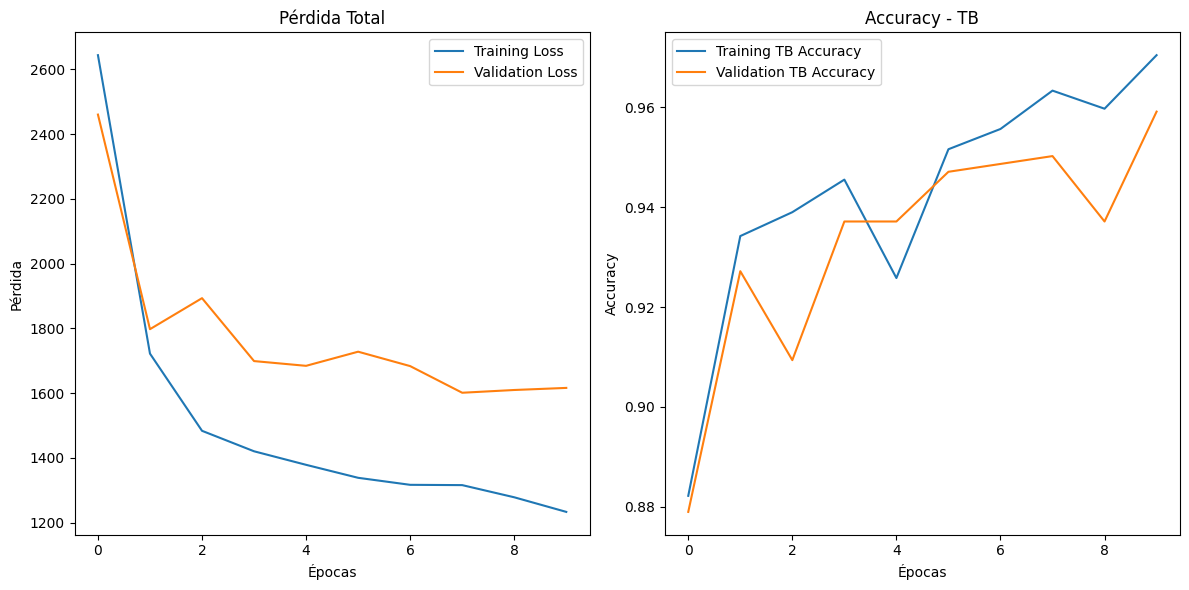

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, classification_report
import matplotlib.pyplot as plt
# Predicciones
preds = model.predict(X_val)
preds_tb = np.argmax(preds[0], axis=1)  # Predicciones de TB
preds_bbox = preds[1]  # Predicciones de Bounding Box
preds_severity = np.argmax(preds[2], axis=1)  # Predicciones de Severidad


# Verdaderos valores
true_tb = np.argmax(y_tb_val, axis=1)
true_bbox = y_bbox_val
true_severity = np.argmax(y_severity_val, axis=1)

### Métricas para TB (Clasificación Binaria)
print("\n--- MÉTRICAS PARA CLASIFICACIÓN TB ---")
print("Accuracy TB:", accuracy_score(true_tb, preds_tb))
print("Precision TB:", precision_score(true_tb, preds_tb))
print("Recall TB:", recall_score(true_tb, preds_tb))
print("F1-Score TB:", f1_score(true_tb, preds_tb))

# Reporte de clasificación completo
print("\nReporte Clasificación TB:\n", classification_report(true_tb, preds_tb))

### Métricas para Bounding Box (Regresión)
print("\n--- MÉTRICAS PARA BOUNDING BOX (Regresión) ---")
mse_bbox = mean_squared_error(true_bbox, preds_bbox)
print("MSE Bounding Box:", mse_bbox)

### Métricas para Severidad (Clasificación Multiclase)
print("\n--- MÉTRICAS PARA CLASIFICACIÓN DE SEVERIDAD ---")
print("Accuracy Severidad:", accuracy_score(true_severity, preds_severity))
print("Precision Severidad:", precision_score(true_severity, preds_severity, average='weighted'))
print("Recall Severidad:", recall_score(true_severity, preds_severity, average='weighted'))
print("F1-Score Severidad:", f1_score(true_severity, preds_severity, average='weighted'))

# Reporte de clasificación completo
print("\nReporte Clasificación Severidad:\n", classification_report(true_severity, preds_severity))

### Gráficas de Pérdida y Métricas
# Gráficas de entrenamiento vs validación
plt.figure(figsize=(12, 6))

# Pérdida Total
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Pérdida Total')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Accuracy de TB
plt.subplot(1, 2, 2)
plt.plot(history.history['tb_output_accuracy'], label='Training TB Accuracy')
plt.plot(history.history['val_tb_output_accuracy'], label='Validation TB Accuracy')
plt.title('Accuracy - TB')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.patches as patches


model = load_model('new_model_locating.h5')

def preprocess_image(img_path, target_size=(128, 128)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load image: {img_path}")
    img_resized = cv2.resize(img, target_size) / 255.0  
    img_resized = np.expand_dims(img_resized, axis=-1)  
    img_resized = np.expand_dims(img_resized, axis=0)   
    return img, img_resized

def display_image_with_bbox(img, bbox, tb_class):
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap='gray')
    if tb_class == "tb" and bbox != "none":
        xmin, ymin, width, height = bbox
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)
        plt.title("Detected TB with Bounding Box")
    else:
        plt.title("No TB Detected")
    plt.axis('off')
    plt.show()

def classify_and_detect_tb():
    img_path = input("Enter the path to the image: ").strip()

    try:
        original_img, input_img = preprocess_image(img_path)
        tb_pred, bbox_pred, _ = model.predict(input_img)
        tb_class = "tb" if tb_pred[0][1] > 0.5 else "no tb"
        if tb_class == "tb":
            scale_x = original_img.shape[1] / 128 
            scale_y = original_img.shape[0] / 128

            xmin = bbox_pred[0][0] * scale_x
            ymin = bbox_pred[0][1] * scale_y
            width = bbox_pred[0][2] * scale_x
            height = bbox_pred[0][3] * scale_y
            bbox = [xmin, ymin, width, height]
        else:
            bbox = "none"
        display_image_with_bbox(original_img, bbox, tb_class)

    except Exception as e:
        print(f"Error processing the image: {e}")
classify_and_detect_tb()


1/1 [==============================] - 0s 53ms/step
TB Prediction (Raw): [[0.04986829 0.95013165]]
Bounding Box Prediction (Raw): [[86.02706  42.847775 47.01929  60.57928 ]]
Original Image Shape: (512, 512)
Bounding Box (Scaled): [44045, 21938, 24073, 31016]


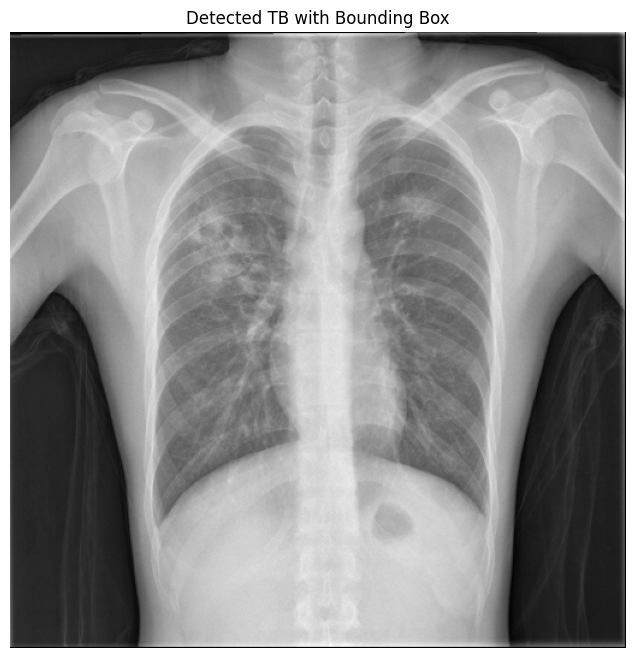

TB Classification: tb
Bounding Box: [44045, 21938, 24073, 31016]


In [10]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.patches as patches


model = load_model('new_model_locating.h5')

def preprocess_image(img_path, target_size=(128, 128)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load image: {img_path}")
    img_resized = cv2.resize(img, target_size) / 255.0 
    img_resized = np.expand_dims(img_resized, axis=-1)  
    img_resized = np.expand_dims(img_resized, axis=0)   
    return img, img_resized

def display_image_with_bbox(img, bbox, tb_class):
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap='gray')
    if tb_class == "tb" and bbox != "none":
       
        xmin, ymin, width, height = bbox
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)
        plt.title("Detected TB with Bounding Box")
    else:
        plt.title("No TB Detected")
    plt.axis('off')
    plt.show()


def classify_and_detect_tb(img_path):
    try:

        original_img, input_img = preprocess_image(img_path)


        tb_pred, bbox_pred, _ = model.predict(input_img)


        print(f"TB Prediction (Raw): {tb_pred}")
        print(f"Bounding Box Prediction (Raw): {bbox_pred}")


        tb_class = "tb" if tb_pred[0][1] > 0.5 else "no tb"

     
        if tb_class == "tb":
        
            print(f"Original Image Shape: {original_img.shape}")

            # Convert bounding box predictions to original image scale
            xmin = int(bbox_pred[0][0] * original_img.shape[1])  # Scale by width
            ymin = int(bbox_pred[0][1] * original_img.shape[0])  # Scale by height
            width = int(bbox_pred[0][2] * original_img.shape[1])  # Scale by width
            height = int(bbox_pred[0][3] * original_img.shape[0])  # Scale by height
            bbox = [xmin, ymin, width, height]

            # Debugging: Print scaled bounding box
            print(f"Bounding Box (Scaled): {bbox}")
        else:
            bbox = "none"

        # Display the image with bounding box (if TB is detected)
        display_image_with_bbox(original_img, bbox, tb_class)

        # Return the results
        return tb_class, bbox

    except Exception as e:
        print(f"Error processing the image: {e}")
        return None, None


# Example usage
img_path = "D:/x-ray chest/locating/TBX11K/imgs/tb/tb0014.png"  # Replace with the actual image path
tb_class, bbox = classify_and_detect_tb(img_path)

if tb_class:
    print(f"TB Classification: {tb_class}")
    if tb_class == "tb":
        print(f"Bounding Box: {bbox}")
    else:
        print("No bounding box as TB is not detected.")
